# Make plots map
Create some plots on a map.

In [1]:
using PyPlot
using NCDatasets
using PyCall
using Dates
using Glob
const plt = PyPlot
ccrs = pyimport("cartopy.crs")
cfeature = pyimport("cartopy.feature")
include("./config.jl")
include("./ME4OH.jl")
mainproj = ccrs.Mollweide(central_longitude=200)
datacrs = ccrs.PlateCarree();
coast = cfeature.GSHHSFeature(scale="h")

[ Info: File already downloaded


PyObject <cartopy.feature.GSHHSFeature object at 0x7aa3fdd845e0>

In [2]:
@info("Figures will be saved in $(figdir)")

[ Info: Figures will be saved in ../figures/


## Observations 

In [3]:
thetimeperiod = timeperiod1
datadirdisk = joinpath(databasedir, "$(thetimeperiod[1])-$(thetimeperiod[end])")
isdir(datadirdisk) ? @info("Data directory exists") : @error("Data directory does't exist")

[ Info: Data directory exists


In [48]:
datafilelist = ME4OH.get_filelist(datadirdisk)
datafile = datafilelist[1]

[ Info: Found 432 files


"/media/ctroupin/T7 Shield/000060826v009/data/en4.1.1/1979-2014/ofam3-jra55.all.EN.4.1.1.f.profiles.g10.197901.update.extra.danom.197901_201412.nc"

In [63]:
for indexlayer = 1:3
    lon, lat, dates, dohc, adohc, dadohc, dohc_mask, bounds, depth_level_thickness = ME4OH.read_profile(datafile);
    goodvalues = goodvalues = .!(isnan.(dohc[indexlayer,:]));
    
    fig = plt.figure()
    ax = plt.subplot(111, projection=mainproj)
    ax.set_global()
    scat = ax.scatter(lon, lat, s=3, c=dohc[indexlayer,:], transform=datacrs)
    cb = plt.colorbar(scat, shrink=.6)
    cb.set_label("TJ/m²", rotation=0, ha="left")
    ax.set_title("Density of Ocean Heat Content\n $(Dates.monthname(Dates.month(dates[1]))) $(Dates.year(dates[1])), layer [$(depthlayers[indexlayer][1])-$(depthlayers[indexlayer][2])] m")
    ax.add_feature(coast, lw=.5, zorder=4)
    fname = "dohc_$(Dates.year(dates[1]))$(lpad(Dates.month(dates[1]), 2, '0'))_layer$(indexlayer)"
    plt.savefig(joinpath(figdir, fname))
    plt.close()
end    

## Gridded fields

In [71]:
outputfile = joinpath(mainoutputdir, "experiment-A/dohc/OHC_1979_2014_lev0_286.6_expA_DIVAnd.nc")

"../output/experiment-A/dohc/OHC_1979_2014_lev0_286.6_expA_DIVAnd.nc"

In [72]:
nc = NCDataset(outputfile, "r")
dates = nc["time"][:]
dohc = nc["dohc"][:,:,:]
close(nc)

closed Dataset

In [75]:
timeindex = findfirst(dates .== DateTime(2005, 1, 1))

313

In [82]:
fig = plt.figure()
ax = plt.subplot(111, projection=mainproj)
ax.set_global()
pcm = ax.pcolormesh(longrid, latgrid, dohc[:,:,timeindex]', transform=datacrs)
cb = plt.colorbar(pcm, shrink=.6)
cb.set_label("TJ/m²", rotation=0, ha="left")
ax.set_title("Interpolated density of Ocean Heat Content\nExperiment A\n $(Dates.monthname(Dates.month(dates[1]))) $(Dates.year(dates[1])), layer [$(depthlayers[indexlayer][1])-$(depthlayers[indexlayer][2])] m")
ax.add_feature(coast, lw=.5, zorder=4)
fname = "dohc_expA_$(Dates.year(dates[1]))$(lpad(Dates.month(dates[1]), 2, '0'))_layer$(indexlayer)"
plt.savefig(joinpath(figdir, fname))
plt.close()
plt.show() 

## Temperature observations

In [37]:
timeperiodtext = "$(thetimeperiod[1])01_$(thetimeperiod[end])12"
fnameprefix = "ofam3-jra55.all.EN.4.1.1.f.profiles.g10"
fnamesuffix = "update.extra.danom"

for mm = 1:12
    @info("Working on month $(mm)")
    datafilelistmonth = glob("$(fnameprefix).*$(lpad(mm, 2, "0")).$(fnamesuffix).$(timeperiodtext).nc", datadirdisk)
    @info("Found $(length(datafilelistmonth)) files")

    obslon, obslat, obsdates, obsdepth, T, S = ME4OH.read_TS_data(datafilelistmonth);
    nobs = length(obslon)
    @info("Total number of observations: $(nobs)")
    
    for thedepth in [obsdepth[1], obsdepth[10], obsdepth[20]]
    
        gooddepth = findall(obsdepth .== thedepth);
    
        fig = plt.figure()
        ax = plt.subplot(111, projection=mainproj)
        ax.set_global()
        scat = ax.scatter(obslon[gooddepth], obslat[gooddepth], s=1, c=T[gooddepth], cmap=plt.cm.RdYlBu_r,
        transform=datacrs)
        cb = plt.colorbar(scat, shrink=.6)
        cb.set_label("°C", rotation=0, ha="left")
        ax.set_title("Temperature observations at $(round(thedepth, digits=1)) m in $(Dates.monthname(mm))\nfor the time period $(thetimeperiod[1]) - $(thetimeperiod[end])")
        ax.add_feature(coast, lw=.5, zorder=4)
        fname = "temperature_month$(lpad(mm, 2, '0'))_depth$(round(thedepth))_period$(thetimeperiod[1])_$(thetimeperiod[end]).jpg"
        plt.savefig(joinpath(figdir, fname))
        #plt.show()
        plt.close()
    end
    
end

## Temperature climatology

In [6]:
thetimeperiod = timeperiod2
climfile = "../output/experiment-C/temperature_climatology_$(thetimeperiod[1])_$(thetimeperiod[end]).nc"
isfile(climfile) ? @info("Working on file $(climfile)") : @error("File doesn't exist")

[ Info: Working on file ../output/experiment-C/temperature_climatology_2005_2014.nc


In [18]:
indexlayer = 1
nc = NCDataset(climfile, "r")
depth = nc["depth"][:]

for mm = 4:5
    @info("Working on month $(mm)")
    
    for thedepth in [depth[1], depth[10], depth[20]]
    
        gooddepth = findfirst(depth .== thedepth);
        @show(gooddepth);
        T = nc["temperature"][:,:,gooddepth,mm]
        thedepth = nc["depth"][indexlayer]
        thedate = nc["time"][mm]
        
        @info(size(T))

        fig = plt.figure()
        ax = plt.subplot(111, projection=mainproj)
        ax.set_global()
        pcm = ax.pcolormesh(longrid, latgrid, T', transform=datacrs, cmap=plt.cm.RdYlBu_r)
        cb = plt.colorbar(pcm, shrink=.6)
        cb.set_label("°C", rotation=0, ha="left")
        ax.set_title("Interpolated temperature at $(thedepth) m\nin $(Dates.monthname(Dates.month(thedate))) [$(thetimeperiod[1])-$(thetimeperiod[end])]")
        ax.add_feature(coast, lw=.5, zorder=4)
        fname = "temperature_clim_month$(lpad(mm, 2, '0'))_depth$(round(thedepth))_period$(thetimeperiod[1])_$(thetimeperiod[end]).jpg"
        plt.savefig(joinpath(figdir, fname))
        plt.close()
        #plt.show() 
        
        
    end
end

close(nc)

gooddepth = 1


[ Info: Working on month 4
[ Info: (360, 180)


gooddepth = 10


[ Info: (360, 180)


gooddepth = 20


[ Info: (360, 180)
[ Info: Working on month 5


gooddepth = 1


[ Info: (360, 180)


gooddepth = 10


[ Info: (360, 180)


gooddepth = 20


[ Info: (360, 180)


closed Dataset

In [12]:
nc = NCDataset(climfile, "r")
depth = nc["depth"][:]
gooddepth = findfirst(depth .== depth[1]);
T = nc["temperature"][:,:,gooddepth,1]
close(nc)

closed Dataset

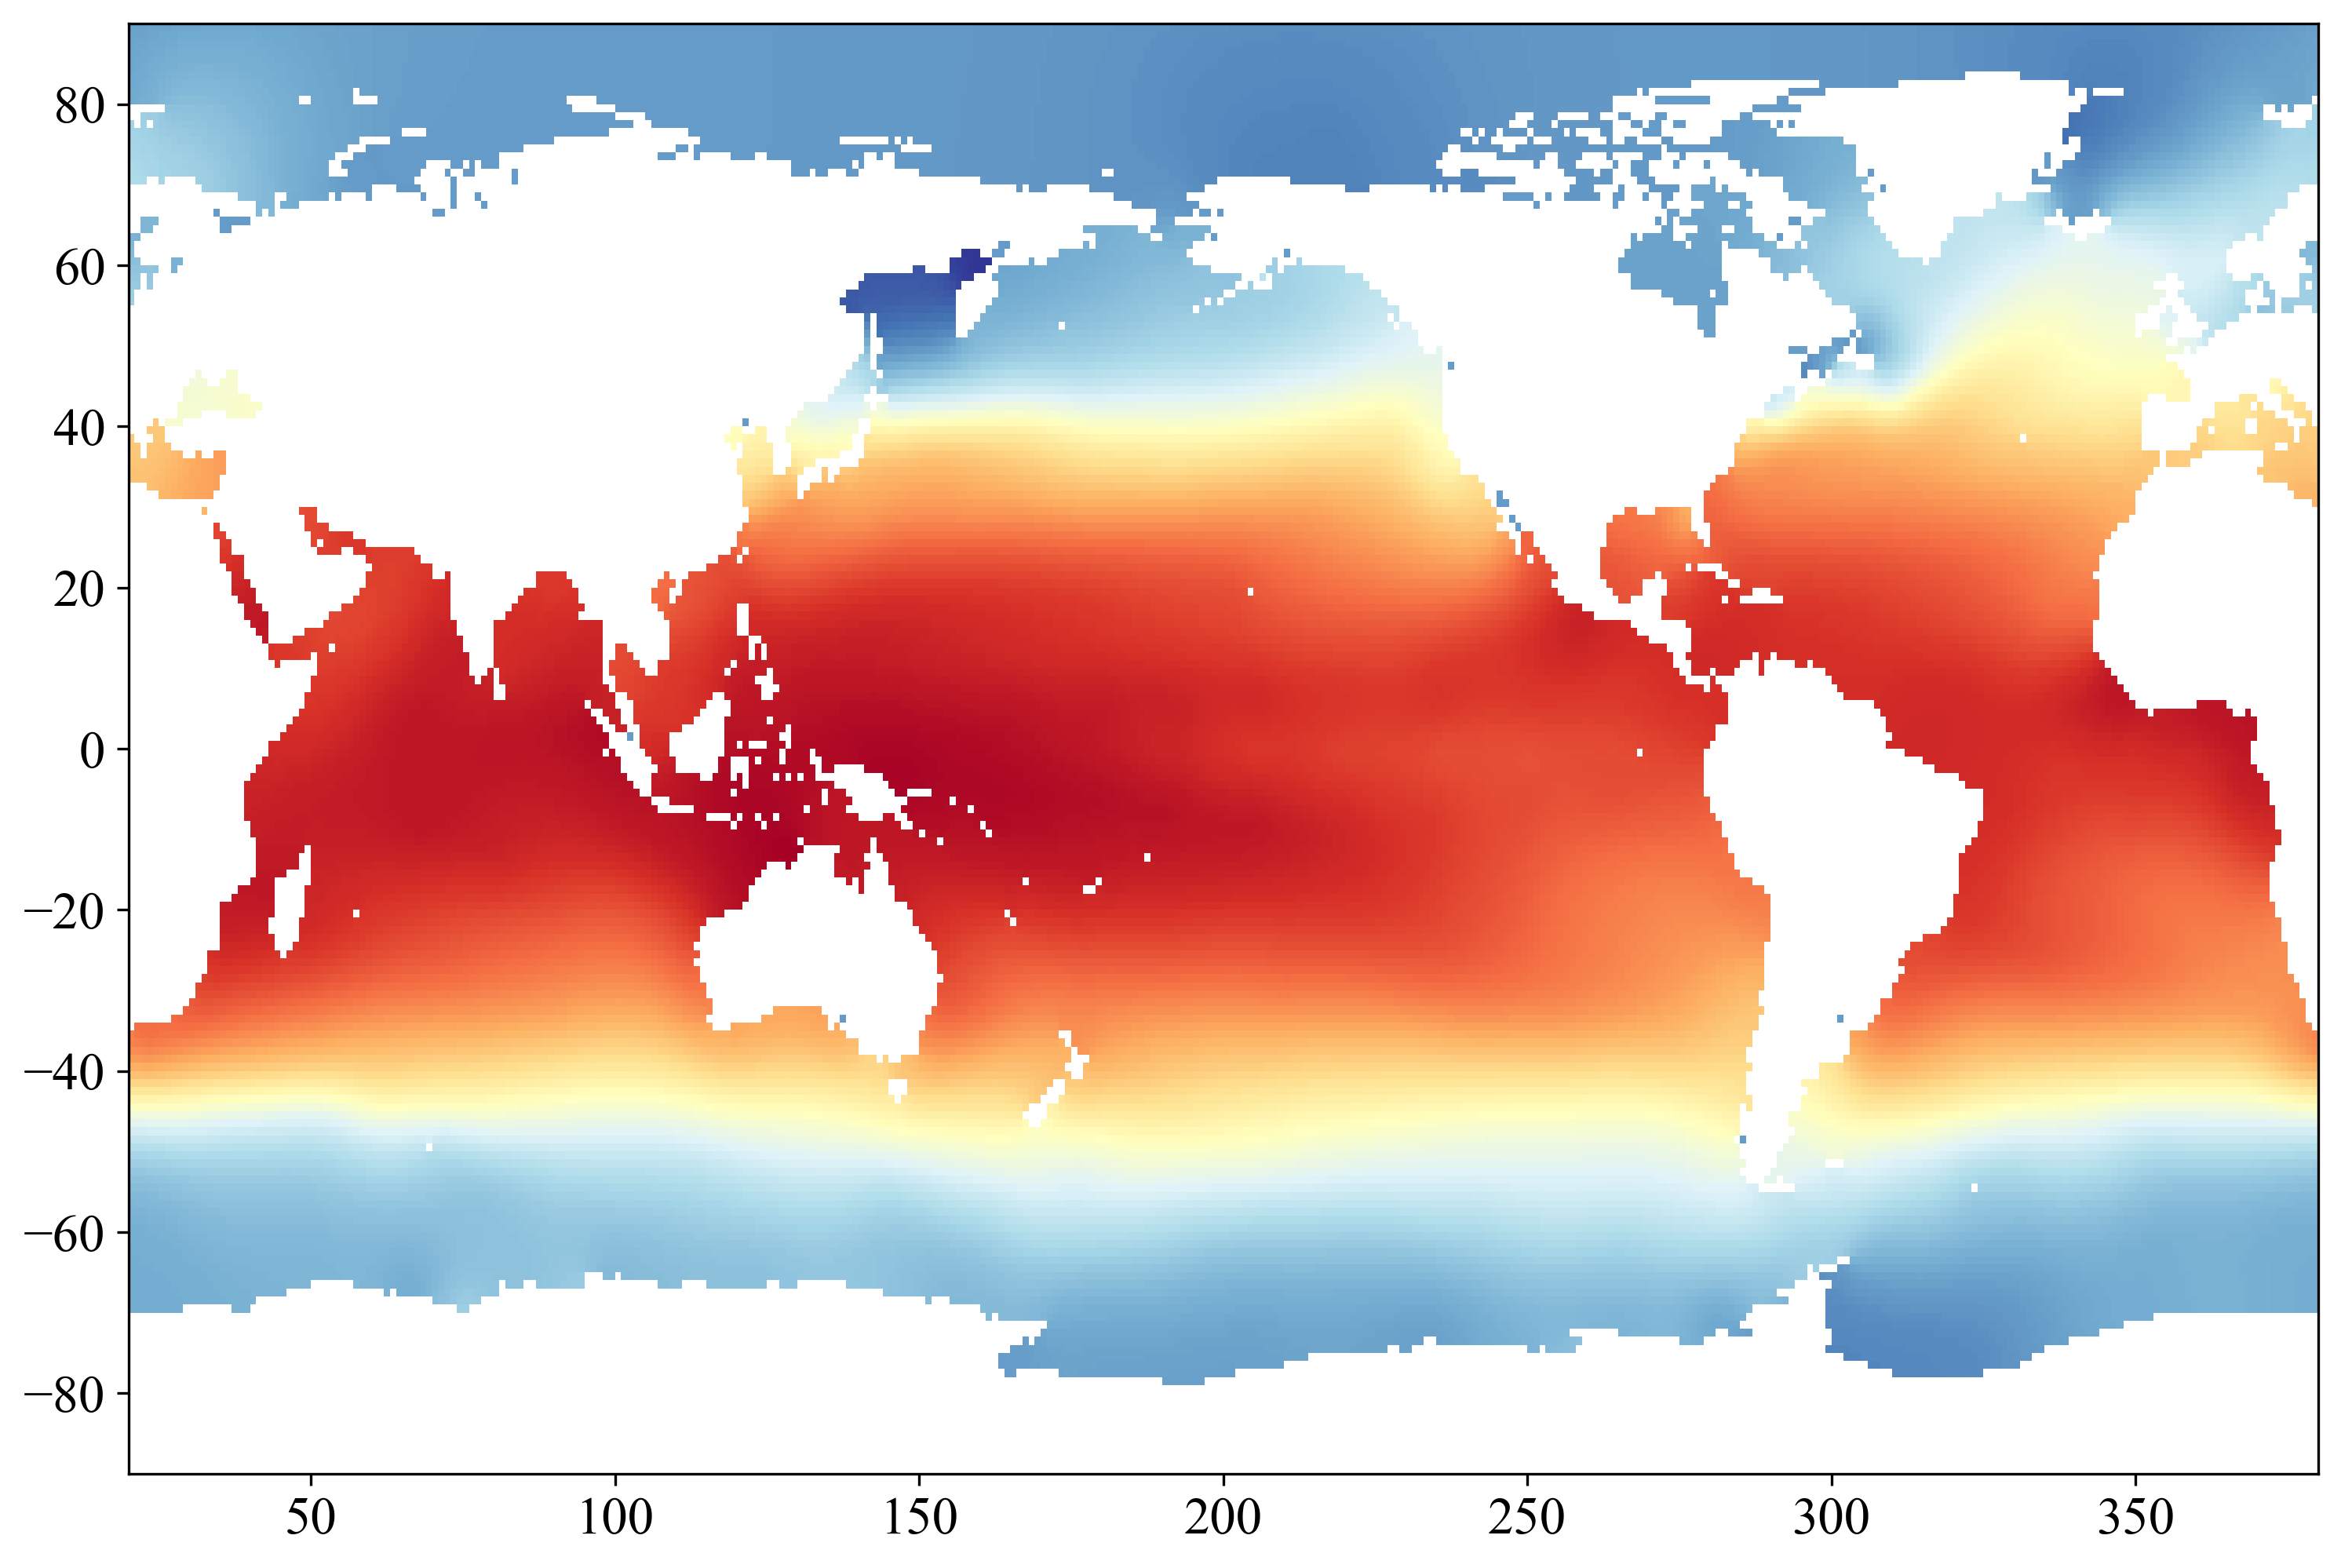

PyObject <matplotlib.collections.QuadMesh object at 0x7aa3cc91f670>

In [14]:
plt.pcolormesh(longrid, latgrid, T', cmap=plt.cm.RdYlBu_r)

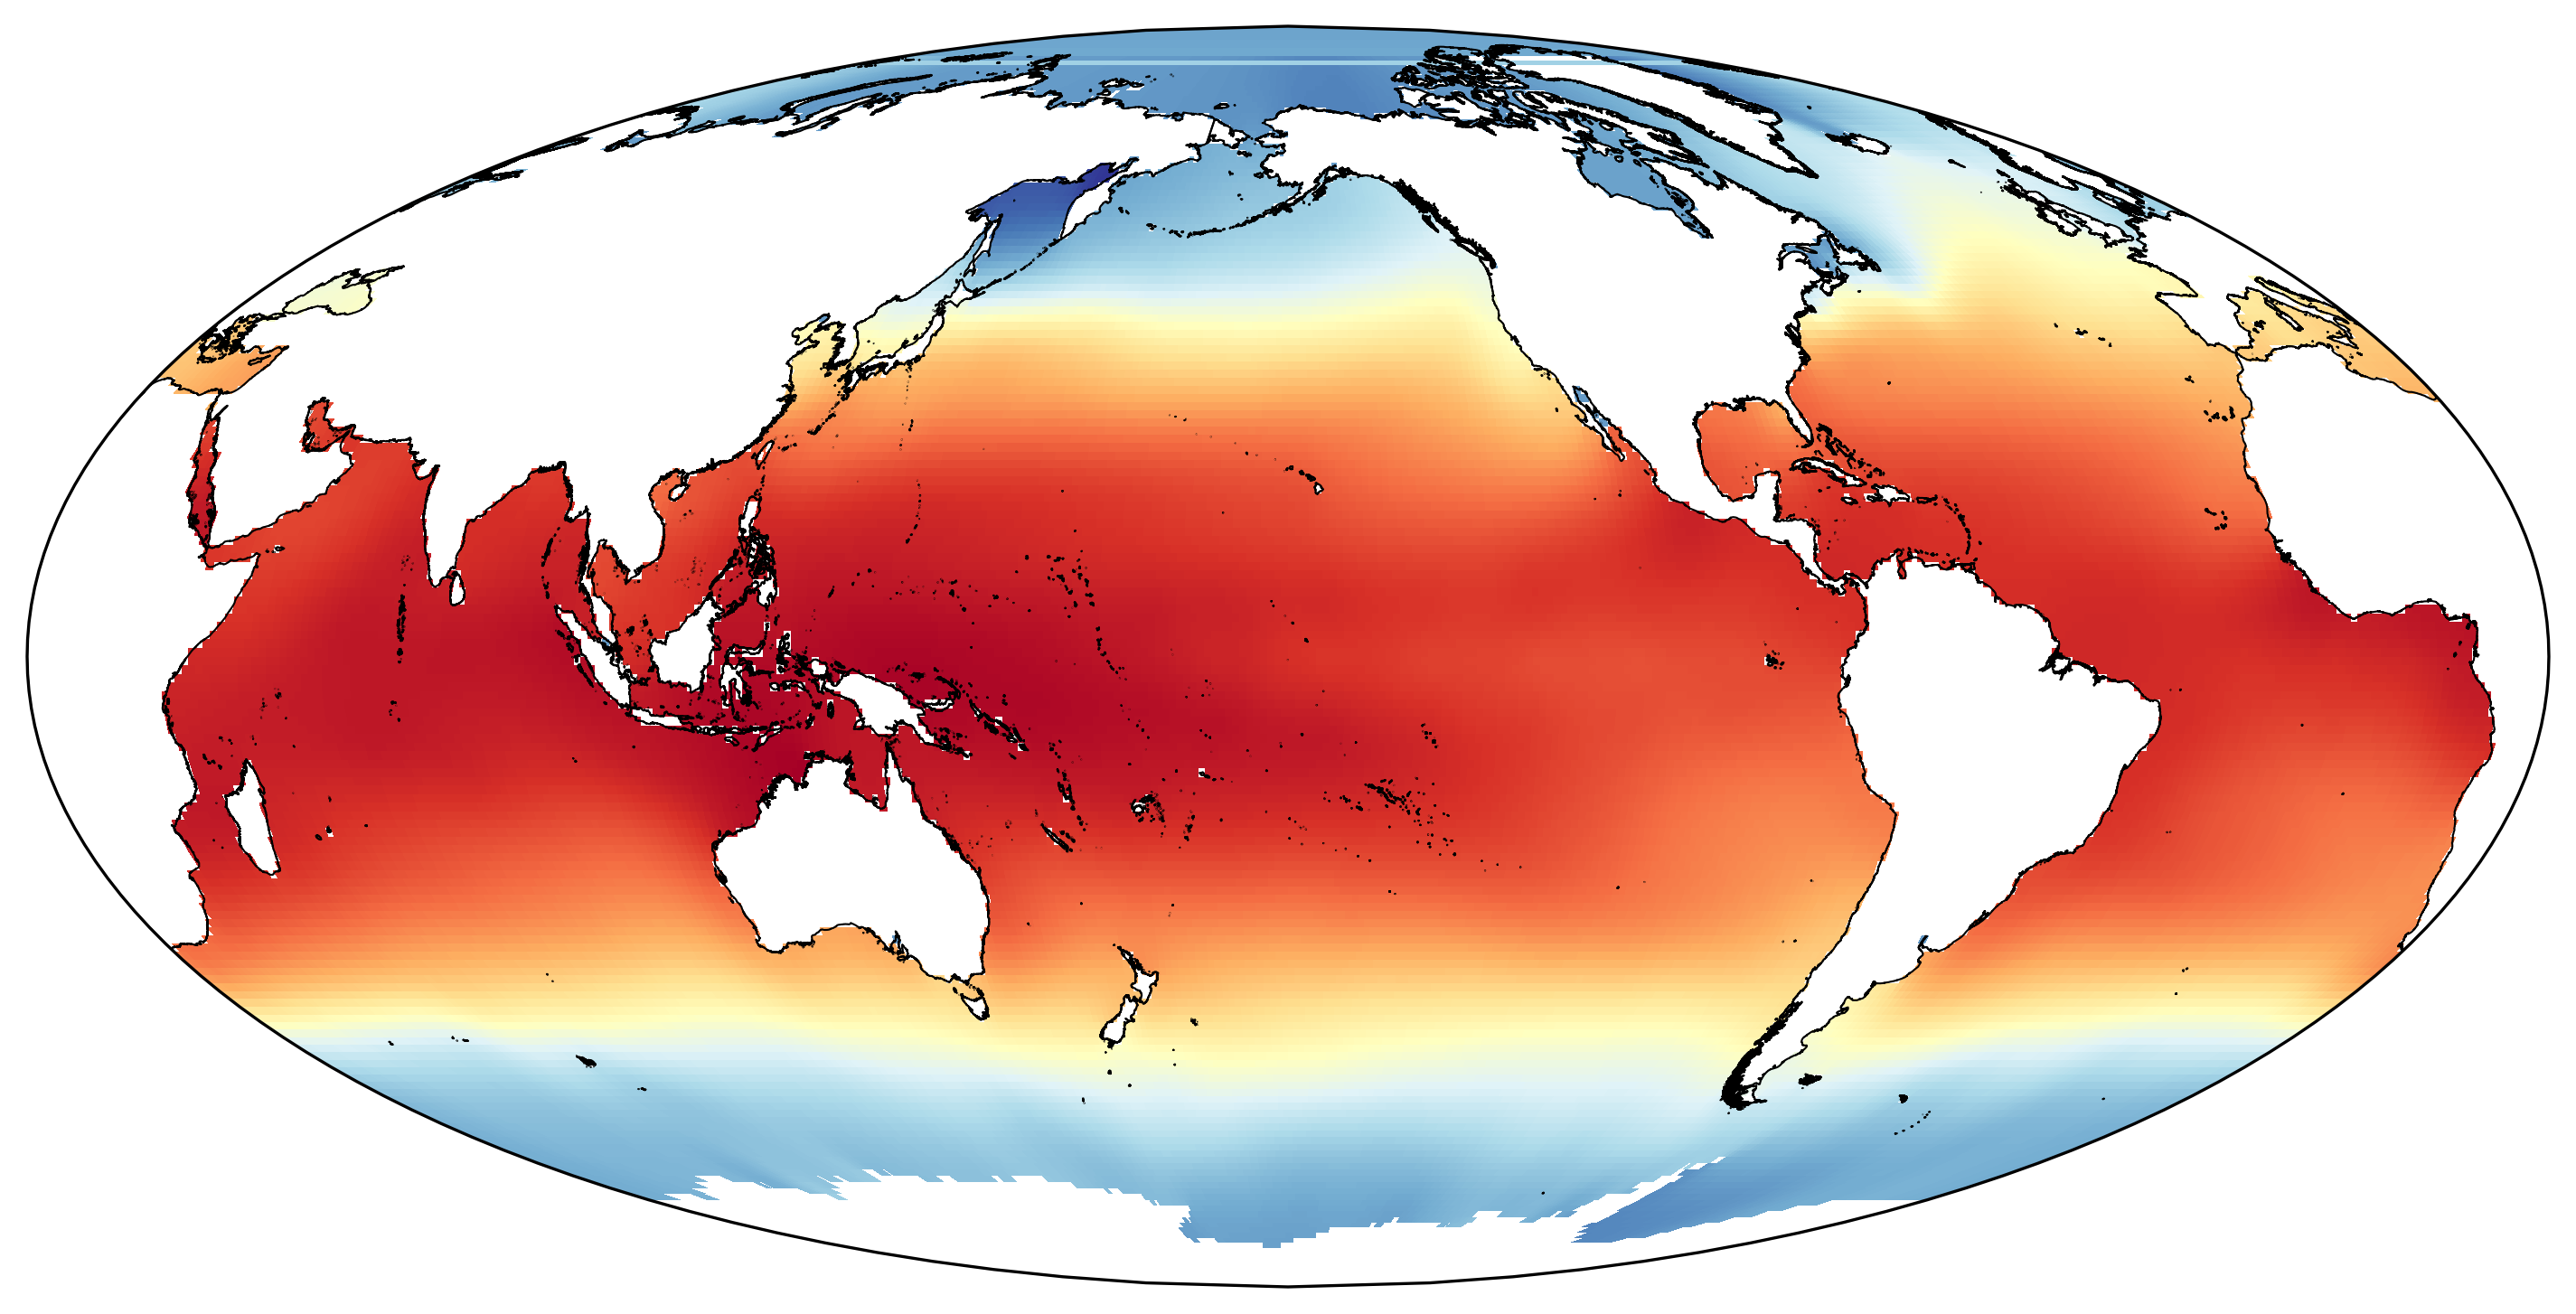

PyObject <cartopy.mpl.feature_artist.FeatureArtist object at 0x7aa3cb7e0160>

In [16]:
fig = plt.figure()
ax = plt.subplot(111, projection=mainproj)
ax.set_global()
pcm = ax.pcolormesh(longrid, latgrid, T', transform=datacrs, cmap=plt.cm.RdYlBu_r)
ax.add_feature(coast, lw=.5, zorder=4)